## Task 6

In [1]:
import numpy as np
from scipy.io import loadmat
from lasso import lasso_ccd
from joblib import Parallel, delayed


data = loadmat("A1_data.mat")
Ttrain = data["Ttrain"].flatten()   # 1D array of training audio samples
Xaudio = data["Xaudio"]            # Regression matrix for audio frames

fs = int(data["fs"].item())  
frame_len = int(0.04 * fs)         # 40 ms frame length in samples (expected to be 352)
print(f"Sampling rate: {fs} Hz, Frame length: {frame_len} samples")

# If Xaudio's row count differs (e.g., 364), adjust frame_len to match Xaudio
if Xaudio.shape[0] != frame_len:
    frame_len = Xaudio.shape[0]
    print(f"Adjusted frame_len to {frame_len} to match Xaudio rows.")

# Calculate number of full frames and reshape Ttrain accordingly
num_frames = Ttrain.shape[0] // frame_len
Ttrain = Ttrain[:num_frames * frame_len]        # drop any incomplete frame at the end
train_frames = Ttrain.reshape(num_frames, frame_len)

print(f"Total samples in Ttrain: {Ttrain.shape[0]}")
print(f"Number of {frame_len}-sample frames: {num_frames}")


Sampling rate: 8820 Hz, Frame length: 352 samples
Total samples in Ttrain: 19360
Number of 352-sample frames: 55


In [2]:
# Prepare lambda grid and number of folds for cross-validation
lambda_vec = np.logspace(-3, 2, 30)   # 30 values from 1e-3 to 1e2 (log scale)
K = 5  

print("Lambda grid:", lambda_vec[[0, 5, 15, -1]])  # show a few lambdas for example
print("Using K-fold cross-validation with K =", K)


Lambda grid: [1.00000000e-03 7.27895384e-03 3.85662042e-01 1.00000000e+02]
Using K-fold cross-validation with K = 5


In [3]:
num_lambdas = len(lambda_vec)
rmse_val_frames = np.zeros((num_frames, num_lambdas))
rmse_est_frames = np.zeros((num_frames, num_lambdas))


In [4]:
def process_frame(i, t_frame, Xaudio, lambda_vec, K=5):
    N = t_frame.shape[0]
    rng = np.random.default_rng(seed=i)  # seed برای reproducibility
    indices = rng.permutation(N)
    fold_size = N // K

    rmse_val = np.zeros(len(lambda_vec))
    rmse_est = np.zeros(len(lambda_vec))

    for k in range(K):
        val_idx = indices[k * fold_size : (k + 1) * fold_size]
        est_idx = np.setdiff1d(indices, val_idx)

        X_est = Xaudio[est_idx, :]
        t_est = t_frame[est_idx].reshape(-1, 1)
        X_val = Xaudio[val_idx, :]
        t_val = t_frame[val_idx].reshape(-1, 1)

        for j, lam in enumerate(lambda_vec):
            w_hat = lasso_ccd(t_est, X_est, lam)
            y_val = X_val @ w_hat
            y_est = X_est @ w_hat
            rmse_val[j] += np.mean((t_val - y_val)**2)
            rmse_est[j] += np.mean((t_est - y_est)**2)

    rmse_val = np.sqrt(rmse_val / K)
    rmse_est = np.sqrt(rmse_est / K)

    return rmse_val, rmse_est

n_test_frames = 55
results = Parallel(n_jobs=-1)( 
    delayed(process_frame)(i, train_frames[i], Xaudio, lambda_vec)
    for i in range(n_test_frames)
)

rmse_val_frames = np.array([r[0] for r in results])
rmse_est_frames = np.array([r[1] for r in results])


Lambda hat: 0.0049


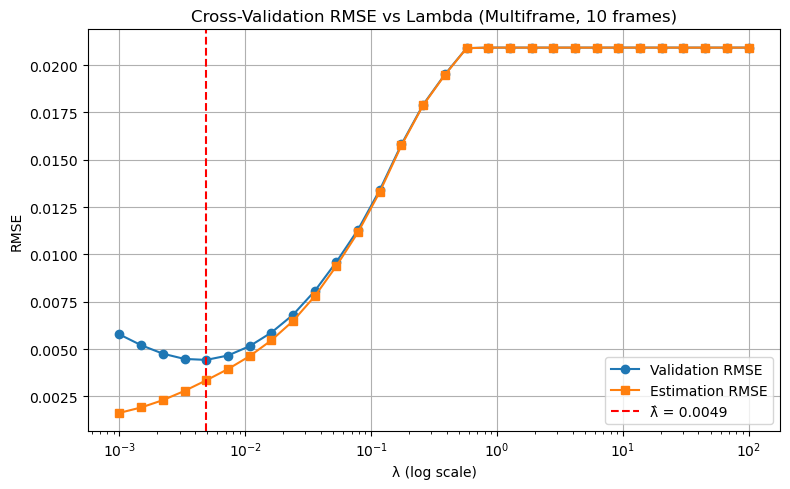

In [5]:
avg_rmse_val = rmse_val_frames.mean(axis=0)
avg_rmse_est = rmse_est_frames.mean(axis=0)
lambda_hat = lambda_vec[np.argmin(avg_rmse_val)]

print(f"Lambda hat: {lambda_hat:.4f}")
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(lambda_vec, avg_rmse_val, marker='o', label='Validation RMSE')
plt.plot(lambda_vec, avg_rmse_est, marker='s', label='Estimation RMSE')
plt.axvline(x=lambda_hat, color='red', linestyle='--', label=f'λ̂ = {lambda_hat:.4f}')
plt.xscale('log')
plt.xlabel('λ (log scale)')
plt.ylabel('RMSE')
plt.title('Cross-Validation RMSE vs Lambda (Multiframe, 10 frames)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Task 7


In [6]:
from lasso import lasso_denoise

Ttest = data["Ttest"].flatten()
Ytest = lasso_denoise(Ttest.reshape(-1, 1), Xaudio, lambda_hat)

np.save("Ytest.npy", Ytest)


0 %
1 %
2 %
2 %
3 %
4 %
4 %
5 %
6 %
7 %
7 %
8 %
9 %
9 %
10 %
11 %
12 %
12 %
13 %
14 %
14 %
15 %
16 %
17 %
17 %
18 %
19 %
19 %
20 %
21 %
22 %
22 %
23 %
24 %
24 %
25 %
26 %
27 %
27 %
28 %
29 %
29 %
30 %
31 %
32 %
32 %
33 %
34 %
34 %
35 %
36 %
37 %
37 %
38 %
39 %
39 %
40 %
41 %
42 %
42 %
43 %
44 %
44 %
45 %
46 %
47 %
47 %
48 %
49 %
49 %
50 %
51 %
52 %
52 %
53 %
54 %
54 %
55 %
56 %
57 %
57 %
58 %
59 %
59 %
60 %
61 %
61 %
62 %
63 %
64 %
64 %
65 %
66 %
66 %
67 %
68 %
69 %
69 %
70 %
71 %
71 %
72 %
73 %
74 %
74 %
75 %
76 %
76 %
77 %
78 %
79 %
79 %
80 %
81 %
81 %
82 %
83 %
84 %
84 %
85 %
86 %
86 %
87 %
88 %
89 %
89 %
90 %
91 %
91 %
92 %
93 %
94 %
94 %
95 %
96 %
96 %
97 %
98 %
99 %
100 %


In [8]:
import sounddevice as sd
sd.play(Ytest, samplerate=fs)


In [11]:
lambda_list = [0.001, 0.0049, 0.01, 0.05, 0.1]
from lasso import lasso_denoise

denoised_versions = {}

for lam in lambda_list:
    print(f"Processing lambda = {lam}")
    y = lasso_denoise(Ttest.reshape(-1, 1), Xaudio, lam)
    denoised_versions[f"lambda_{lam}"] = y
    np.save(f"Ytest_lambda_{lam}.npy", y)

Processing lambda = 0.001
0 %
1 %
2 %
2 %
3 %
4 %
4 %
5 %
6 %
7 %
7 %
8 %
9 %
9 %
10 %
11 %
12 %
12 %
13 %
14 %
14 %
15 %
16 %
17 %
17 %
18 %
19 %
19 %
20 %
21 %
22 %
22 %
23 %
24 %
24 %
25 %
26 %
27 %
27 %
28 %
29 %
29 %
30 %
31 %
32 %
32 %
33 %
34 %
34 %
35 %
36 %
37 %
37 %
38 %
39 %
39 %
40 %
41 %
42 %
42 %
43 %
44 %
44 %
45 %
46 %
47 %
47 %
48 %
49 %
49 %
50 %
51 %
52 %
52 %
53 %
54 %
54 %
55 %
56 %
57 %
57 %
58 %
59 %
59 %
60 %
61 %
61 %
62 %
63 %
64 %
64 %
65 %
66 %
66 %
67 %
68 %
69 %
69 %
70 %
71 %
71 %
72 %
73 %
74 %
74 %
75 %
76 %
76 %
77 %
78 %
79 %
79 %
80 %
81 %
81 %
82 %
83 %
84 %
84 %
85 %
86 %
86 %
87 %
88 %
89 %
89 %
90 %
91 %
91 %
92 %
93 %
94 %
94 %
95 %
96 %
96 %
97 %
98 %
99 %
100 %
Processing lambda = 0.0049
0 %
1 %
2 %
2 %
3 %
4 %
4 %
5 %
6 %
7 %
7 %
8 %
9 %
9 %
10 %
11 %
12 %
12 %
13 %
14 %
14 %
15 %
16 %
17 %
17 %
18 %
19 %
19 %
20 %
21 %
22 %
22 %
23 %
24 %
24 %
25 %
26 %
27 %
27 %
28 %
29 %
29 %
30 %
31 %
32 %
32 %
33 %
34 %
34 %
35 %
36 %
37 %
37 %
38 %
39 %

In [13]:
for lam in lambda_list:
    print(f"Playing λ = {lam}")
    sd.play(denoised_versions[f"lambda_{lam}"], samplerate=fs)
    sd.wait()

Playing λ = 0.001
Playing λ = 0.0049
Playing λ = 0.01
Playing λ = 0.05
Playing λ = 0.1
